# DeepFM

이번 실습에서는 DeepFM 모델을 이해하고 구현해보겠습니다.  

DeepFM 모델은 Factorization machines와 neural network를 합친 모델로, Wide & Deep model과 유사하지만, feature engineering이 필요하지 않다는 특징을 가지고 있습니다.  
<br/>
사용자가 영화에 대해 Rating한 데이터, 영화의 장르 데이터를 이용하여 Train/Test data를 생성한 다음, Train data로 학습한 모델을 Test data에 대해 평가해봅니다.   
사용한 데이터는 Implicit feedback data로, 사용자가 시청한 영화(Positive instances)는 rating = 1로 기록됩니다. 따라서 시청하지 않은 영화에 대해 각 유저별로 Negative instances sampling을 진행합니다.   
<br/>
**구현에 앞서, DeepFM 논문을 꼭 읽어보시길 권장합니다.**

* 참고  
    - DeepFM: A Factorization-Machine based Neural Network for CTR Prediction (https://arxiv.org/pdf/1703.04247.pdf)  
    - Wide & Deep Learning for Recommender Systems (https://arxiv.org/pdf/1606.07792.pdf)
    - Factorization Machines (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5694074)
    - https://d2l.ai/chapter_recommender-systems/deepfm.html

# Modules

In [2]:
import csv
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

# Data preprocessing
0. Dataset 다운로드  
<br/>
1. Rating df 생성  
rating 데이터(train_ratings.csv)를 불러와 [user, item, rating]의 컬럼으로 구성된 데이터 프레임을 생성합니다.   
<br/>
2. Genre df 생성   
genre 정보가 담긴 데이터(genres.tsv)를 불러와 genre이름을 id로 변경하고, [item, genre]의 컬럼으로 구성된 데이터 프레임을 생성합니다.    
<br/>
3. Negative instances 생성   
rating 데이터는 implicit feedback data(rating :0/1)로, positive instances로 구성되어 있습니다. 따라서 rating이 없는 item중 negative instances를 뽑아서 데이터에 추가하게 됩니다.   
<br/>
4. Join dfs   
rating df와 genre df를 join하여 [user, item, rating, genre]의 컬럼으로 구성된 데이터 프레임을 생성합니다.   
<br/>
5. zero-based index로 mapping   
Embedding을 위해서 user,item,genre를 zero-based index로 mapping합니다.
    - user : 0-31359
    - item : 0-6806
    - genre : 0-17  
<br/>
6. feature matrix X, label tensor y 생성   
[user, item, genre] 3개의 field로 구성된 feature matrix를 생성합니다.   
<br/>
7. data loader 생성

In [3]:
# 1. Rating df 생성
rating_data = "../../data/train/train_ratings.csv"

raw_rating_df = pd.read_csv(rating_data)
raw_rating_df['rating'] = 1.0 # implicit feedback
raw_rating_df.drop(['time'],axis=1,inplace=True)
print("Raw rating df")
print(raw_rating_df)

users = set(raw_rating_df.loc[:, 'user'])
items = set(raw_rating_df.loc[:, 'item'])

#2. Genre df 생성
genre_data = "../../data/train/genres.tsv"

raw_genre_df = pd.read_csv(genre_data, sep='\t')
raw_genre_df = raw_genre_df.drop_duplicates(subset=['item']) #item별 하나의 장르만 남도록 drop
#print("Raw genre df")
#print(raw_genre_df)

genre_dict = {genre:i for i, genre in enumerate(set(raw_genre_df['genre']))}
raw_genre_df['genre']  = raw_genre_df['genre'].map(lambda x : genre_dict[x]) #genre id로 변경
print("Raw genre df - changed to id")
print(raw_genre_df)

Raw rating df
           user   item  rating
0            11   4643     1.0
1            11    170     1.0
2            11    531     1.0
3            11    616     1.0
4            11   2140     1.0
...         ...    ...     ...
5154466  138493  44022     1.0
5154467  138493   4958     1.0
5154468  138493  68319     1.0
5154469  138493  40819     1.0
5154470  138493  27311     1.0

[5154471 rows x 3 columns]
Raw genre df - changed to id
         item  genre
0         318     11
2        2571      0
5        2959      0
9         296     15
13        356     15
...       ...    ...
15925   73106     15
15926  109850      0
15929    8605      0
15931    3689     15
15932    8130      1

[6807 rows x 2 columns]


In [4]:
# 3. Negative instance 생성
print("Create Nagetive instances")
num_negative = 50
user_group_dfs = list(raw_rating_df.groupby('user')['item'])
first_row = True
user_neg_dfs = pd.DataFrame()

for u, u_items in tqdm(user_group_dfs):
    u_items = set(u_items)
    i_user_neg_item = np.random.choice(list(items - u_items), num_negative, replace=False)
    
    i_user_neg_df = pd.DataFrame({'user': [u]*num_negative, 'item': i_user_neg_item, 'rating': [0]*num_negative})
    if first_row == True:
        user_neg_dfs = i_user_neg_df
        first_row = False
    else:
        user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

raw_rating_df = pd.concat([raw_rating_df, user_neg_dfs], axis = 0, sort=False)

# 4. Join dfs
joined_rating_df = pd.merge(raw_rating_df, raw_genre_df, left_on='item', right_on='item', how='inner')
# print("Joined rating df")
# print(joined_rating_df)

# 5. user, item을 zero-based index로 mapping
users = list(set(joined_rating_df.loc[:,'user']))
users.sort()
items =  list(set((joined_rating_df.loc[:, 'item'])))
items.sort()
genres =  list(set((joined_rating_df.loc[:, 'genre'])))
genres.sort()

if len(users)-1 != max(users):
    users_dict = {users[i]: i for i in range(len(users))}
    joined_rating_df['user']  = joined_rating_df['user'].map(lambda x : users_dict[x])
    users = list(set(joined_rating_df.loc[:,'user']))
    
if len(items)-1 != max(items):
    items_dict = {items[i]: i for i in range(len(items))}
    joined_rating_df['item']  = joined_rating_df['item'].map(lambda x : items_dict[x])
    items =  list(set((joined_rating_df.loc[:, 'item'])))

joined_rating_df = joined_rating_df.sort_values(by=['user'])
joined_rating_df.reset_index(drop=True, inplace=True)

data = joined_rating_df
print("Data")
print(data)

n_data = len(data)
n_user = len(users)
n_item = len(items)
n_genre = len(genres)

print("# of data : {}\n# of users : {}\n# of items : {}\n# of genres : {}".format(n_data, n_user, n_item, n_genre))

Create Nagetive instances


100%|██████████| 31360/31360 [05:24<00:00, 96.67it/s] 


Data
          user  item  rating  genre
0            0  2505     1.0      0
1            0  2464     1.0     15
2            0  4708     0.0      5
3            0  3303     1.0     15
4            0  5221     1.0      3
...        ...   ...     ...    ...
6722466  31359  4403     1.0      0
6722467  31359  4069     1.0      4
6722468  31359  4071     1.0      3
6722469  31359  2851     1.0      4
6722470  31359  6377     0.0      5

[6722471 rows x 4 columns]
# of data : 6722471
# of users : 31360
# of items : 6807
# of genres : 18


In [5]:
#6. feature matrix X, label tensor y 생성
user_col = torch.tensor(data.loc[:,'user'])
item_col = torch.tensor(data.loc[:,'item'])
genre_col = torch.tensor(data.loc[:,'genre'])

offsets = [0, n_user, n_user+n_item]
for col, offset in zip([user_col, item_col, genre_col], offsets):
    col += offset

X = torch.cat([user_col.unsqueeze(1), item_col.unsqueeze(1), genre_col.unsqueeze(1)], dim=1)
y = torch.tensor(list(data.loc[:,'rating']))


#7. data loader 생성
class RatingDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.input_tensor = input_tensor.long()
        self.target_tensor = target_tensor.long()

    def __getitem__(self, index):
        return self.input_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.target_tensor.size(0)


dataset = RatingDataset(X, y)
train_ratio = 0.9

train_size = int(train_ratio * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

   # Model architecture (DeepFM)
   DeepFM 모델은 1) FM component와  2) Deep component가 병렬적으로 결합되어 있습니다. 구조는 다음과 같습니다.
<img src='https://drive.google.com/uc?id=1vwcxUJQTIsg5QH9CuH5PcUEfExhToUHR'>  
각 구조는 다음과 같습니다.  
   **1. FM component**  
       FM component는 우리가 아는 2-way Factorization machines(degree=2)입니다. FM은 variables 간의 interaction을 다음과 같이 모델링 합니다.   
     **<center> equation (1) </center>**
   $$\hat{y}(x):=w_0 + \sum_{i=1}^{n}w_ix_i + \sum_{i=1}^{n}\sum_{j=i+1}^{n}<\mathbf{v}_i,\mathbf{v}_j>x_ix_j$$   
   이때, 세번째 interaction term을 전개하여 다음과 같이 쓸 수 있습니다.(논문 참고)  
   구현 코드는 전개된 식을 바탕으로 합니다.   
     **<center> equation (2)> </center>**
   $$\sum_{i=1}^{n}\sum_{j=i+1}^{n}<\mathbf{v}_i,\mathbf{v}_j>x_ix_j = \frac{1}{2}\sum_{f=1}^{k}((\sum_{i=1}^{n}v_{i,f}x_i)^2-\sum_{i=1}^{n}v_{i,f}^2x_i^2)$$   
           
   **2. Deep component**  
       Deep component는 MLP Layers로 구성되어 있습니다.   
       구현 코드는 Input dimension이 30-20-10인 3 layer MLP 구조입니다.
  
   

# Model

In [6]:
class DeepFM(nn.Module):
    def __init__(self, input_dims, embedding_dim, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        total_input_dim = int(sum(input_dims)) # n_user + n_movie + n_genre

        # Fm component의 constant bias term과 1차 bias term
        self.bias = nn.Parameter(torch.zeros((1,)))
        self.fc = nn.Embedding(total_input_dim, 1)
        
        self.embedding = nn.Embedding(total_input_dim, embedding_dim) 
        self.embedding_dim = len(input_dims) * embedding_dim

        mlp_layers = []
        for i, dim in enumerate(mlp_dims):
            if i==0:
                mlp_layers.append(nn.Linear(self.embedding_dim, dim))
            else:
                mlp_layers.append(nn.Linear(mlp_dims[i-1], dim)) #TODO 1 : linear layer를 넣어주세요.
            mlp_layers.append(nn.ReLU(True))
            mlp_layers.append(nn.Dropout(drop_rate))
        mlp_layers.append(nn.Linear(mlp_dims[-1], 1))
        self.mlp_layers = nn.Sequential(*mlp_layers)

    def fm(self, x):
        # x : (batch_size, total_num_input)
        embed_x = self.embedding(x)

        fm_y = self.bias + torch.sum(self.fc(x), dim=1)
        square_of_sum = torch.sum(embed_x, dim=1) ** 2         #TODO 2 : torch.sum을 이용하여 square_of_sum을 작성해주세요(hint : equation (2))
        sum_of_square = torch.sum(embed_x ** 2, dim=1)         #TODO 3 : torch.sum을 이용하여 sum_of_square을 작성해주세요(hint : equation (2))
        fm_y += 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True)
        return fm_y
    
    def mlp(self, x):
        embed_x = self.embedding(x)
        
        inputs = embed_x.view(-1, self.embedding_dim)
        mlp_y = self.mlp_layers(inputs)
        return mlp_y

    def forward(self, x):
        embed_x = self.embedding(x)
        #fm component
        fm_y = self.fm(x).squeeze(1)
        
        #deep component
        mlp_y = self.mlp(x).squeeze(1)
        
        y = torch.sigmoid(fm_y + mlp_y)
        return y


# Training

In [7]:
device = torch.device('cuda')
input_dims = [n_user, n_item, n_genre]
embedding_dim = 10
model = DeepFM(input_dims, embedding_dim, mlp_dims=[30, 20, 10]).to(device)
bce_loss = nn.BCELoss() # Binary Cross Entropy loss
lr, num_epochs = 0.01, 10
optimizer = optim.Adam(model.parameters(), lr=lr)

for e in tqdm(range(num_epochs)) :
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x)
        loss = bce_loss(output, y.float())
        loss.backward()
        optimizer.step()
        

100%|██████████| 10/10 [11:22<00:00, 68.23s/it]


# Evaluation
평가는 모델이 postive instance에 대해 0.5이상, negative instance에 대해 0.5미만의 값을 예측한 Accuracy를 측정하여 진행됩니다.

In [15]:
# 랭킹 문제에 맞게 학습하고 있는지 확인하기 위해 구현할 필요성이 있음 => TODO
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [16]:
correct_result_sum = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    model.eval()
    output = model(x)
    result = torch.round(output)
    correct_result_sum += (result == y).sum().float()

acc = correct_result_sum/len(test_dataset)*100
print("Final Acc : {:.2f}%".format(acc.item()))

Final Acc : 90.37%


# Inference

In [18]:
# 모든 유저-아이템을 인풋으로 넣어서 결과 생성 후 랭킹 (31360 x 6807)
u_list = []
i_list = []
ritems_dict = {v:k for k,v in items_dict.items()}
for u, u_items in tqdm(user_group_dfs):

    # 인코딩하기 전에 유저id 저장
    u_list.append([u]*10)

    # user_group_dfs은 인코딩 이전 값이므로 사용하기 위해 인코딩 진행
    u = users_dict[u]
    u_items = set(u_items.map(lambda x : items_dict[x]))    # 인덱스로 활용 가능!

    # user, item, genre 데이터를 인코딩하여 학습한 모델에 맞는 값으로 변환
    i_user_col = torch.tensor([u] * n_item)
    i_item_col = torch.tensor(raw_genre_df['item'].map(lambda x : items_dict[x]).values)
    i_genre_col = torch.tensor(raw_genre_df['genre'].values)
    for col, offset in zip([i_user_col, i_item_col, i_genre_col], offsets):
        col += offset
    
    x = torch.cat([i_user_col.unsqueeze(1), i_item_col.unsqueeze(1), i_genre_col.unsqueeze(1)], dim=1)
    x = x.to(device)

    model.eval()
    output_batch = model(x)
    output_batch = output_batch.cpu().detach().numpy()

    output_batch[list(u_items)] = -1    # -np.inf, 분포 확인을 위해 교체 / 이미 본 아이템 제외
    result_batch = np.argsort(output_batch)[-10:][::-1] # 역방향 -> 정방향으로 수정
    i_list.append(list(map(lambda x : ritems_dict[x], result_batch)))  # 아이템 디코딩, ndarray는 map()이 안돼서 다른 방법 찾음

100%|██████████| 31360/31360 [02:40<00:00, 195.43it/s]


In [11]:
u_list = np.concatenate(u_list)
i_list = np.concatenate(i_list)

In [12]:
submit_df = pd.DataFrame(data={'user': u_list, 'item': i_list}, columns=['user', 'item'])

In [13]:
if not os.path.exists("./submit/"):
    os.makedirs("./submit/")
submit_df.to_csv("./submit/"+"deepfm_submission.csv", index=False)

# 결과 분석

array([0.4048093 , 0.9463241 , 0.99749917, 0.9871672 , 0.9080806 ,
       0.9202605 , 0.98203284, 0.48849568, 0.01342629, 0.84310085],
      dtype=float32)

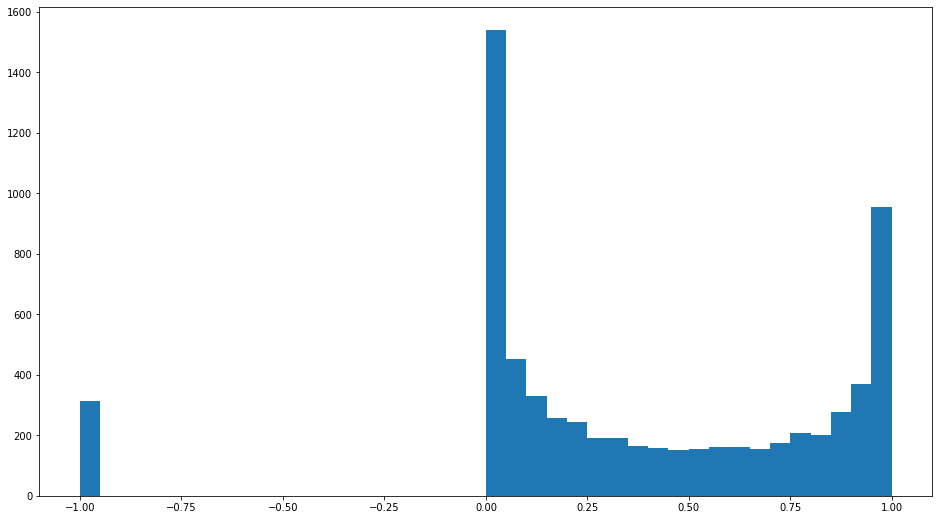

In [26]:
# Inference 에서 마지막 유저에 대한 모델 아웃풋이 저장되는 output batch를 활용하여 내용물을 열어보자
plt.figure(figsize=(16,9))
plt.hist(output_batch, 40)
tmp = list(map(lambda x : items_dict[x], [2012,2628,1270,33615,36401,2011,589,2712,2340,593]))  # 현재 best 결과의 가장 마지막 유저의 submission 파일을 가져와서 찾아봄
output_batch[tmp]   # 대략적인 경계를 0.95 정도로 생각하면 타율이 6할...

# DeepFM의 경우 현재의 방식으로는 랭킹 문제에 적합하지 않는다고 생각해서 => classification으로 학습하여 랭킹에 적합하게 값이 생성되지는 않았을 것으로 생각된다 그러나 구분은 어느정도 괜찮게 하지 않았을까?
# candidate generation(후보군 생성)에 사용할 수 있는지 확인하기 위해 열어봤는데, 결과가 좀 애매하네요?
# => 현재 우리 코드에서는 DeepFM 결과를 가져와서 multi-ae의 결과를 screening하는 것이 가장 간단할 듯?

### **콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

